In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import ttest_ind, f_oneway, chi2_contingency
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.font_manager as fm
import matplotlib as mpl
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

In [7]:
# 나눔 폰트 실행 

!apt-get update -qq
!apt-get install fonts-nanum* -qq
!rm ~/.cache/matplotlib -rf

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=20).get_name() # 기본 폰트 사이즈 : 20
plt.rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline

E: 잠금 파일 /var/lib/apt/lists/lock 파일을 열 수 없습니다 - open (13: 허가 거부)
E: /var/lib/apt/lists/ 디렉터리를 잠글 수 없습니다
W: /var/cache/apt/pkgcache.bin 파일을 삭제하는데 문제가 있습니다 - RemoveCaches (13: 허가 거부)
W: /var/cache/apt/srcpkgcache.bin 파일을 삭제하는데 문제가 있습니다 - RemoveCaches (13: 허가 거부)
E: 잠금 파일 /var/lib/dpkg/lock-frontend 파일을 열 수 없습니다 - open (13: 허가 거부)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


## 데이터 불러오기

In [58]:
df = pd.read_csv("/home/piai/train/01 실습파일/2. Big Data 분석/Car.csv")
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.6 kmpl,998 CC,58.16 bhp,5.0,NaN
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN


In [59]:
# 데이터 정보 확인 : info() 함수

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7253 non-null   object 
 1   Location           7253 non-null   object 
 2   Price              6200 non-null   float64
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   object 
 9   Engine             7207 non-null   object 
 10  Power              7207 non-null   object 
 11  Seats              7200 non-null   float64
 12  New_Price          1006 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 736.8+ KB


In [60]:
# 결측치(True) 현황 요약 : sum() 함수

df.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                  46
Seats                  53
New_Price            6247
dtype: int64

In [61]:
# Owner_type, New_Price 열 제거

df.drop(columns=['Owner_Type','New_Price'], inplace=True)
df.shape

(7253, 11)

In [62]:
#중복 데이터 제거

df.drop_duplicates(ignore_index=True)

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,26.6 kmpl,998 CC,58.16 bhp,5.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,19.67 kmpl,1582 CC,126.2 bhp,5.0
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,18.2 kmpl,1199 CC,88.7 bhp,5.0
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,20.77 kmpl,1248 CC,88.76 bhp,7.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,15.2 kmpl,1968 CC,140.8 bhp,5.0
...,...,...,...,...,...,...,...,...,...,...,...
7246,Volkswagen Vento Diesel Trendline,Hyderabad,NaN,2011,89411,Diesel,Manual,20.54 kmpl,1598 CC,103.6 bhp,5.0
7247,Volkswagen Polo GT TSI,Mumbai,NaN,2015,59000,Petrol,Automatic,17.21 kmpl,1197 CC,103.6 bhp,5.0
7248,Nissan Micra Diesel XV,Kolkata,NaN,2012,28000,Diesel,Manual,23.08 kmpl,1461 CC,63.1 bhp,5.0
7249,Volkswagen Polo GT TSI,Pune,NaN,2013,52262,Petrol,Automatic,17.2 kmpl,1197 CC,103.6 bhp,5.0


> 데이터 전처리

* Price 가격 전처리

In [63]:
df['Price'] = df.groupby('Name')['Price'].transform(lambda x: x.fillna(x.mean()))

In [64]:
df.isnull().sum()

Name                   0
Location               0
Price                126
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Mileage                2
Engine                46
Power                 46
Seats                 53
dtype: int64

-> 나머지 126개는 mean값으로 채워지지 못했으므로 삭제함

In [65]:
# Price에서 남은 결측치 행 삭제

df.dropna(subset=['Price'], inplace=True)
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,26.6 kmpl,998 CC,58.16 bhp,5.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,19.67 kmpl,1582 CC,126.2 bhp,5.0
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,18.2 kmpl,1199 CC,88.7 bhp,5.0
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,20.77 kmpl,1248 CC,88.76 bhp,7.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,15.2 kmpl,1968 CC,140.8 bhp,5.0


In [66]:
df.isnull().sum()

Name                  0
Location              0
Price                 0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Mileage               2
Engine               42
Power                42
Seats                48
dtype: int64

* Na 값이면 삭제

In [67]:
df = df.dropna(subset = ['Mileage','Engine', 'Power'], inplace=False)

In [68]:
df.isnull().sum()

Name                 0
Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Mileage              0
Engine               0
Power                0
Seats                6
dtype: int64

* seats 변수 전처리

In [69]:
# 'Name' 열에서 'Maruti Estilo LXI'만 필터링하여 출력합니다.
maruti_estilo_lxi = df.loc[df['Name'] == 'Maruti Estilo LXI']

# 결과 출력
maruti_estilo_lxi

#5인승

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats
2369,Maruti Estilo LXI,Chennai,2299.44,2008,56000,Petrol,Manual,19.5 kmpl,1061 CC,null bhp,NaN
3882,Maruti Estilo LXI,Kolkata,3832.40,2010,40000,Petrol,Manual,19.5 kmpl,1061 CC,null bhp,NaN
5893,Maruti Estilo LXI,Chennai,2682.68,2008,51000,Petrol,Manual,19.5 kmpl,1061 CC,null bhp,NaN


In [70]:
# 'Name' 열에서 'Ford Endeavour Hurricane LE'만 필터링하여 출력합니다.
ford_endeavour_hurricane = df.loc[df['Name'] == 'Ford Endeavour Hurricane LE']

# 결과 출력
ford_endeavour_hurricane

#7인승

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats
3800,Ford Endeavour Hurricane LE,Mumbai,10730.72,2012,129000,Diesel,Automatic,12.8 kmpl,2953 CC,null bhp,NaN


In [71]:
# 'Name' 열에서 'Ford Figo Diesel'만 필터링하여 출력합니다.
ford_figo_diesel = df.loc[df['Name'] == 'Ford Figo Diesel']

# 결과 출력
ford_figo_diesel

#5인승

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats
229,Ford Figo Diesel,Bangalore,5518.66,2015,70436,Diesel,Manual,0.0 kmpl,1498 CC,99 bhp,NaN


In [72]:
# 'Name' 열에서 'Honda City 1.5 EXI'만 필터링하여 출력합니다.
honda_city_exi = df.loc[df['Name'] == 'Honda City 1.5 EXI']

# 결과 출력
honda_city_exi

#5인승

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats
1279,Honda City 1.5 EXI,Pune,1762.90,2005,98437,Petrol,Manual,13.0 kmpl,1493 CC,100 bhp,5.0
1917,Honda City 1.5 EXI,Jaipur,2606.03,2005,88000,Petrol,Manual,13.0 kmpl,1493 CC,100 bhp,NaN
3721,Honda City 1.5 EXI,Jaipur,1686.26,2005,123000,Petrol,Manual,13.0 kmpl,1493 CC,100 bhp,5.0
3806,Honda City 1.5 EXI,Pune,2222.79,2001,125943,Petrol,Manual,13.0 kmpl,1493 CC,100 bhp,5.0
5957,Honda City 1.5 EXI,Coimbatore,2698.01,2004,186679,Petrol,Manual,13.0 kmpl,1493 CC,100 bhp,5.0


In [73]:
# 'Name' 열에서 'Honda Jazz 2020 Petrol'만 필터링하여 출력합니다.
honda_jazz_2020 = df.loc[df['Name'] == 'Honda Jazz 2020 Petrol']

# 결과 출력
honda_jazz_2020

#5인승

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats


In [74]:
df["Seats"].fillna(5, inplace=True)

In [75]:
# 결측치(True) 현황 요약 :sum 함수
df.isnull().sum()

Name                 0
Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Mileage              0
Engine               0
Power                0
Seats                0
dtype: int64

In [76]:
# 하나만 7이라서, 5로 다 채운 후 7로 하나만 채움
#3800번 행의 'Seats' 열을 7로 업데이트합니다.
df.at[3800, 'Seats'] = 7

# 업데이트된 결과 확인
updated_row_3900 = df.loc[3800]
updated_row_3900

Name                 Ford Endeavour Hurricane LE
Location                                  Mumbai
Price                                   10730.72
Year                                        2012
Kilometers_Driven                         129000
Fuel_Type                                 Diesel
Transmission                           Automatic
Mileage                                12.8 kmpl
Engine                                   2953 CC
Power                                   null bhp
Seats                                        7.0
Name: 3800, dtype: object

* 단위를 가지는 데이터, 단위와 분리하고 단위 삭제

In [77]:
# 마일리지 값과 단위 분리
df[['Mileage', 'Mileage_UNIT']] = df['Mileage'].str.split(expand = True)
df[['Power', 'Power_UNIT']] = df['Power'].str.split(' ', expand = True)
df[['Engine', 'Engine_UNIT']] = df['Engine'].str.split(' ', expand = True)

df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats,Mileage_UNIT,Power_UNIT,Engine_UNIT
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,26.6,998,58.16,5.0,kmpl,bhp,CC
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,19.67,1582,126.2,5.0,kmpl,bhp,CC
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,18.2,1199,88.7,5.0,kmpl,bhp,CC
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,20.77,1248,88.76,7.0,kmpl,bhp,CC
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,15.2,1968,140.8,5.0,kmpl,bhp,CC


In [78]:
# 분리된 마일리지 단위 변수 삭제
df = df.drop(['Mileage_UNIT','Power_UNIT','Engine_UNIT'], axis = 1)

df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,26.6,998,58.16,5.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,19.67,1582,126.2,5.0
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,18.2,1199,88.7,5.0
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,20.77,1248,88.76,7.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,15.2,1968,140.8,5.0


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7083 entries, 0 to 7252
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7083 non-null   object 
 1   Location           7083 non-null   object 
 2   Price              7083 non-null   float64
 3   Year               7083 non-null   int64  
 4   Kilometers_Driven  7083 non-null   int64  
 5   Fuel_Type          7083 non-null   object 
 6   Transmission       7083 non-null   object 
 7   Mileage            7083 non-null   object 
 8   Engine             7083 non-null   object 
 9   Power              7083 non-null   object 
 10  Seats              7083 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 922.1+ KB


In [80]:
# df_cleaned에서 'Power' 열의 'null' 값을 NaN으로 변환
df['Power'] = df['Power'].replace('null', np.nan).astype(float)

In [81]:
df.isnull().sum()

Name                   0
Location               0
Price                  0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Mileage                0
Engine                 0
Power                125
Seats                  0
dtype: int64

In [82]:
nan_powers = df[df['Power'].isnull()].groupby('Name').size()
print(nan_powers)
sum_nan_powers = sum(nan_powers)
sum_nan_powers

Name
Audi A4 3.2 FSI Tiptronic Quattro           1
Chevrolet Optra 1.6 Elite                   1
Fiat Petra 1.2 EL                           1
Fiat Siena 1.2 ELX                          1
Ford Endeavour Hurricane LE                 1
Ford Endeavour XLT TDCi 4X4                 1
Ford Fiesta 1.4 SXi TDCi                    4
Ford Fiesta 1.6 SXI ABS Duratec             1
Honda CR-V Sport                            1
Hyundai Santro AT                           1
Hyundai Santro DX                           1
Hyundai Santro GLS I - Euro I               2
Hyundai Santro GLS I - Euro II              3
Hyundai Santro GS                           1
Hyundai Santro GS zipDrive - Euro II        1
Hyundai Santro LP - Euro II                 1
Hyundai Santro LS zipPlus                   2
Hyundai Santro Xing XG eRLX Euro III        2
Hyundai Santro Xing XL                      7
Hyundai Santro Xing XL AT eRLX Euro II      1
Hyundai Santro Xing XL AT eRLX Euro III     1
Hyundai Santro Xing XL eRLX E

125

In [83]:
df['Power'] = df['Power'].replace('null bhp', pd.NA)

In [84]:
# Hyundai Santro 차량들만 필터링
santro_cars = df[df['Name'].str.contains('Hyundai Santro', na=False)]

# Hyundai Santro 차량들의 'Power' 열의 평균값 계산 (NaN 제외)
santro_power_mean = santro_cars['Power'].mean()

# Hyundai Santro 차량들 중 'Power' 열의 결측치를 평균값으로 채우기
df.loc[df['Name'].str.contains('Hyundai Santro', na=False), 'Power'] = df.loc[df['Name'].str.contains('Hyundai Santro', na=False), 'Power'].fillna(santro_power_mean)

In [85]:
# Ford Endeavour 차량들만 필터링
santro_cars = df[df['Name'].str.contains('Ford Endeavour', na=False)]

# Ford Endeavour 차량들의 'Power' 열의 평균값 계산 (NaN 제외)
santro_power_mean = santro_cars['Power'].mean()

# Ford Endeavour 차량들 중 'Power' 열의 결측치를 평균값으로 채우기
df.loc[df['Name'].str.contains('Ford Endeavour', na=False), 'Power'] = df.loc[df['Name'].str.contains('Ford Endeavour', na=False), 'Power'].fillna(santro_power_mean)

In [86]:
# Ford Fiesta 1.4 SXi TDCi 차량들만 필터링
santro_cars = df[df['Name'].str.contains('Ford Fiesta 1.4 SXi TDCi', na=False)]

# Ford Fiesta 1.4 SXi TDCi차량들의 'Power' 열의 평균값 계산 (NaN 제외)
santro_power_mean = santro_cars['Power'].mean()

# Ford Fiesta 1.4 SXi TDCi 차량들 중 'Power' 열의 결측치를 평균값으로 채우기
df.loc[df['Name'].str.contains('Ford Fiesta 1.4 SXi TDCi', na=False), 'Power'] = df.loc[df['Name'].str.contains('Ford Fiesta 1.4 SXi TDCi', na=False), 'Power'].fillna(santro_power_mean)

In [87]:
# Maruti Swift 차량들만 필터링
santro_cars = df[df['Name'].str.contains('Maruti Swift', na=False)]

# Maruti Swift 차량들의 'Power' 열의 평균값 계산 (NaN 제외)
santro_power_mean = santro_cars['Power'].mean()

# Maruti Swift 차량들 중 'Power' 열의 결측치를 평균값으로 채우기
df.loc[df['Name'].str.contains('Maruti Swift', na=False), 'Power'] = df.loc[df['Name'].str.contains('Maruti Swift', na=False), 'Power'].fillna(santro_power_mean)

In [88]:
# Toyota Etios 차량들만 필터링
santro_cars = df[df['Name'].str.contains('Toyota Etios', na=False)]

# Toyota Etios 차량들의 'Power' 열의 평균값 계산 (NaN 제외)
santro_power_mean = santro_cars['Power'].mean()

# Toyota Etios 차량들 중 'Power' 열의 결측치를 평균값으로 채우기
df.loc[df['Name'].str.contains('Toyota Etios', na=False), 'Power'] = df.loc[df['Name'].str.contains('Toyota Etios', na=False), 'Power'].fillna(santro_power_mean)

In [89]:
# Ford Endeavour 차량들만 필터링
santro_cars = df[df['Name'].str.contains('Maruti E', na=False)]

# Ford Endeavour 차량들의 'Power' 열의 평균값 계산 (NaN 제외)
santro_power_mean = santro_cars['Power'].mean()

# Ford Endeavour 차량들 중 'Power' 열의 결측치를 평균값으로 채우기
df.loc[df['Name'].str.contains('Maruti E', na=False), 'Power'] = df.loc[df['Name'].str.contains('Maruti E', na=False), 'Power'].fillna(santro_power_mean)

In [90]:
nan_powers = df[df['Power'].isnull()].groupby('Name').size()
print(nan_powers)
sum_nan_powers = sum(nan_powers)
sum_nan_powers

Name
Audi A4 3.2 FSI Tiptronic Quattro       1
Chevrolet Optra 1.6 Elite               1
Fiat Petra 1.2 EL                       1
Fiat Siena 1.2 ELX                      1
Ford Fiesta 1.6 SXI ABS Duratec         1
Honda CR-V Sport                        1
Mahindra Bolero ZLX                     1
Mahindra Jeep MM 540 DP                 1
Mahindra Jeep MM 550 PE                 1
Maruti 1000 AC                          1
Maruti Baleno LXI - BSIII               1
Maruti Baleno Vxi                       1
Mercedes-Benz E-Class 220 CDI           2
Nissan Micra Diesel                     1
Nissan Teana 230jM                      3
Porsche Cayman 2009-2012 S              1
Porsche Cayman 2009-2012 S tiptronic    1
Skoda Laura Classic 1.8 TSI             1
Smart Fortwo CDI AT                     1
Tata Indica DLS                         4
Toyota Qualis Fleet A3                  1
Toyota Qualis RS E2                     1
Volkswagen Jetta 2007-2011 1.9 L TDI    1
dtype: int64


29

In [91]:
#결측치 있는 행 제거
df_drona = df.dropna(subset=['Power'])

In [92]:
#결측치 확인
nan_powers = df_drona[df_drona['Power'].isnull()].groupby('Name').size()
print(nan_powers)
sum_nan_powers = sum(nan_powers)
sum_nan_powers

Series([], dtype: int64)


0

In [93]:
# 데이터 전처리
# Location 열을 라벨 인코딩하여 정수로 변환.
# Name 열에서 각 이름의 앞 두 단어만 남김.

label_encoder = LabelEncoder()
df_drona['Location'] = label_encoder.fit_transform(df_drona['Location'])

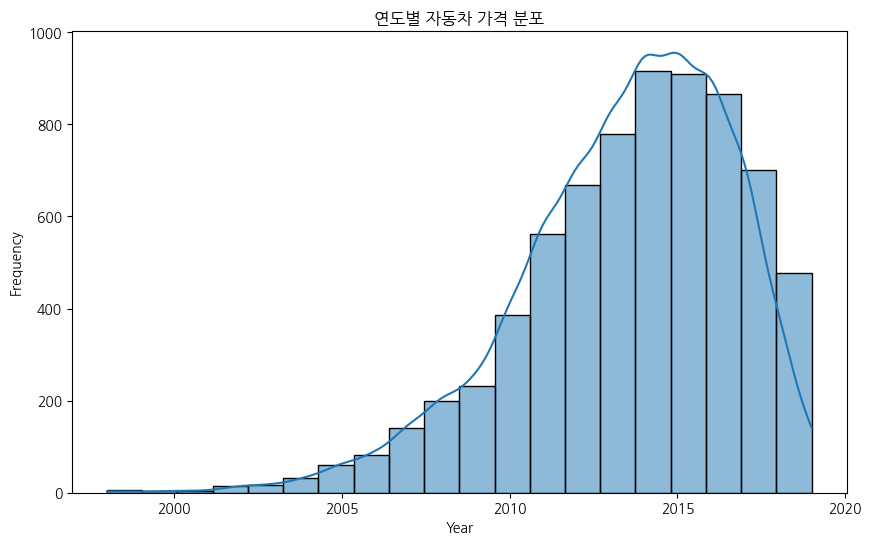

In [94]:
plt.figure(figsize=(10, 6))
sns.histplot(df_drona, x='Year', bins=20, kde=True)
plt.title('연도별 자동차 가격 분포')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

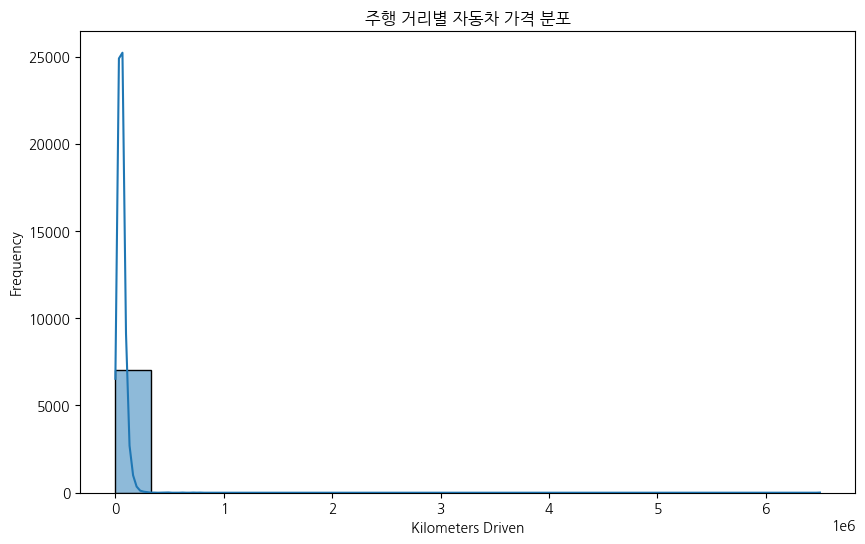

In [95]:
# 주행 거리별 자동차 가격 분포
plt.figure(figsize=(10, 6))
sns.histplot(df_drona, x='Kilometers_Driven', bins=20, kde=True)
plt.title('주행 거리별 자동차 가격 분포')
plt.xlabel('Kilometers Driven')
plt.ylabel('Frequency')
plt.show()

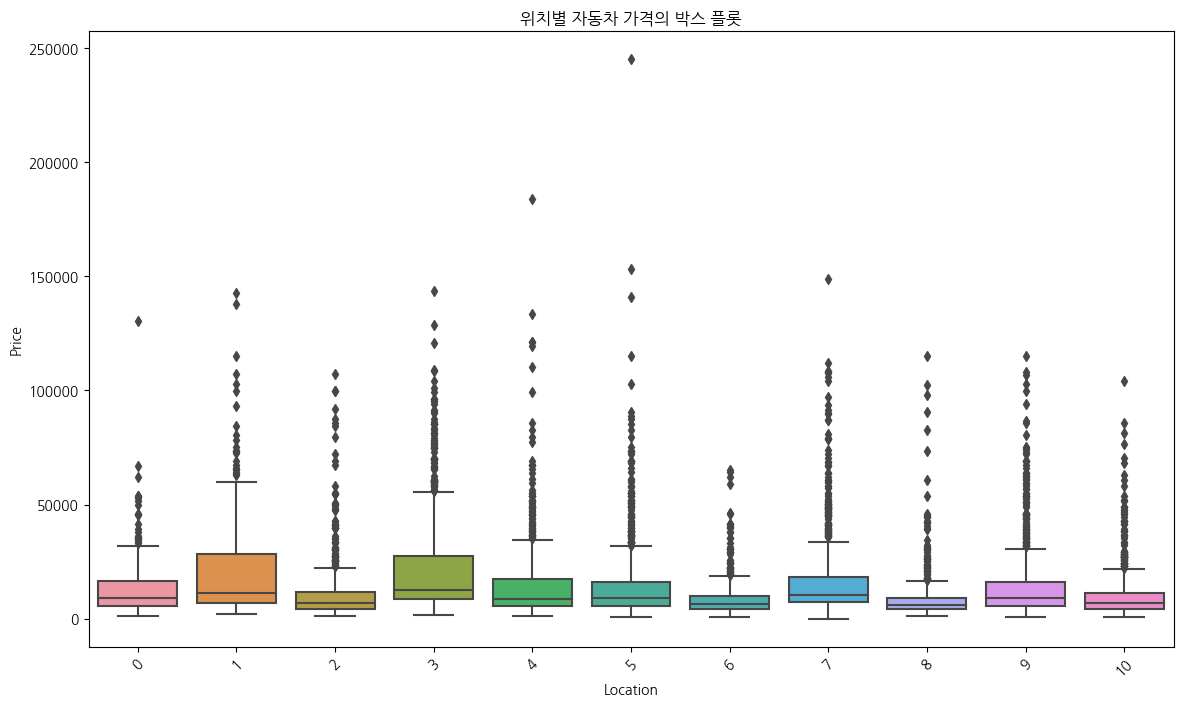

In [96]:
# 위치별 자동차 가격의 박스 플롯
plt.figure(figsize=(14, 8))
sns.boxplot(x='Location', y='Price', data=df_drona)
plt.title('위치별 자동차 가격의 박스 플롯')
plt.xlabel('Location')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

그래프 그리기
 1.연도별 자동차 가격 분포
 2.주행 거리별 자동차 가격 분포
 3.위치별 자동차 가격의 박스 플롯

그래프 분석 결과
 2015년 연식의 자동차까지는 판매량이 증가하다 점차 감소
 주행 거리가 많을수록 자동차 가격이 낮아진다

In [97]:
# T-검정: 2010년과 2015년의 평균 자동차 가격 비교
prices_2010 = df_drona[df_drona['Year'] == 2010]['Price']
prices_2015 = df_drona[df_drona['Year'] == 2015]['Price']

t_stat, p_value = ttest_ind(prices_2010, prices_2015, nan_policy='omit')
print(f"T-test result: t_stat={t_stat}, p_value={p_value}")

# ANOVA (F-검정): 여러 위치의 자동차 가격 평균 비교
grouped_prices = [df_raw[df_raw['Location'] == loc]['Price'] for loc in df_raw['Location'].unique()]
grouped_prices_cleaned = [group.dropna() for group in grouped_prices]

f_stat, p_value = f_oneway(*grouped_prices_cleaned)
print(f"ANOVA result: f_stat={f_stat}, p_value={p_value}")

# 카이제곱 검정: Location과 Fuel_Type 간의 독립성 검정
contingency_table = pd.crosstab(df_raw['Location'], df_raw['Fuel_Type'])
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared test result: chi2_stat={chi2_stat}, p_value={p_val}, dof={dof}")

T-test result: t_stat=-9.38203455613607, p_value=2.800522451628911e-20


NameError: name 'df_raw' is not defined

In [ ]:
df['Name'].value_counts()

In [ ]:
df_drona['Name'] = df['Name'].apply(lambda x : ' '.join(x.split()[:1]))
df_drona['Name'].describe()

In [98]:
name_counts = df_drona['Name'].value_counts()
names_to_keep = name_counts[name_counts > 10].index
df_drona = df_drona[df_drona['Name'].isin(names_to_keep)]

df_drona['Name'].value_counts()

Mahindra XUV500 W8 2WD                        55
Maruti Swift VDI                              49
Maruti Swift Dzire VDI                        42
Honda City 1.5 S MT                           39
Maruti Swift VDI BSIV                         37
                                              ..
Mercedes-Benz New C-Class 220 CDI AT          11
Hyundai Elantra CRDi SX                       11
Honda City i DTEC VX                          11
Hyundai Creta 1.6 SX Plus Petrol Automatic    11
Toyota Innova 2.5 G4 Diesel 8-seater          11
Name: Name, Length: 139, dtype: int64

In [99]:
print(df_drona) 

                                  Name  Location         Price  Year  \
0               Maruti Wagon R LXI CNG         9   2682.680000  2010   
1     Hyundai Creta 1.6 CRDi SX Option        10  19162.000000  2015   
3                    Maruti Ertiga VDI         2   9197.760000  2012   
6               Nissan Micra Diesel XV         6   5365.360000  2013   
12               Maruti Swift VDI BSIV         6   8584.580000  2015   
...                                ...       ...           ...   ...   
7246         Hyundai Grand i10 AT Asta         3   8879.670625  2016   
7247           Hyundai EON D Lite Plus         3   4692.133333  2015   
7249            Volkswagen Polo GT TSI         9  10564.010000  2015   
7250            Nissan Micra Diesel XV         8   5004.021429  2012   
7251            Volkswagen Polo GT TSI        10  10564.010000  2013   

      Kilometers_Driven Fuel_Type Transmission Mileage Engine   Power  Seats  
0                 72000       CNG       Manual    26.6  

* Kilometers_Driven 함수 전처리

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff85f2e5210>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff85f2e57e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff85f2e5390>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff85f2e5d20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff85f2e6590>],
 'means': []}

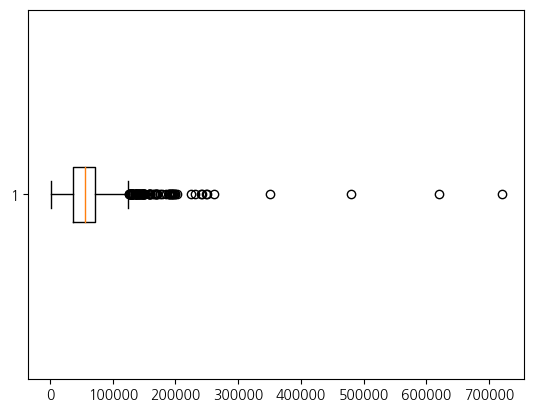

In [100]:
plt.boxplot(df_drona['Kilometers_Driven'].dropna(), vert=False)

In [101]:
Q1 = df['Kilometers_Driven'].quantile(0.25)
Q3 = df['Kilometers_Driven'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_kilo = df_drona[~((df_drona['Kilometers_Driven'] < lower_bound) | (df_drona['Kilometers_Driven'] > upper_bound))]

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff86688e860>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff86688eef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff86688ddb0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff86688f550>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff86688f520>],
 'means': []}

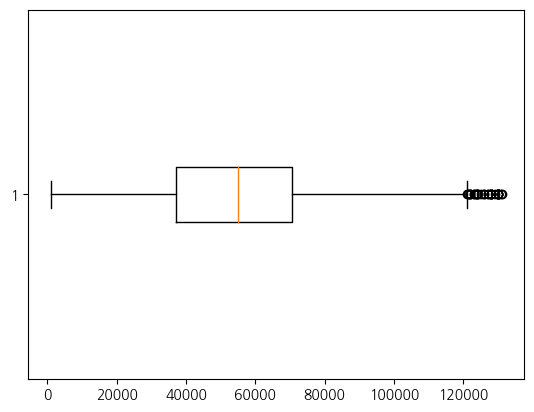

In [102]:
plt.boxplot(df_kilo['Kilometers_Driven'].dropna(), vert=False)

1번
하한값과 상한값 기준을 정해서 처리한 데이터
하한값: Q1−1.5×IQRQ1−1.5×IQR
상한값: Q3+1.5×IQRQ3+1.5×IQR
이 기준을 벗어나는 이상치가 258개 있음
기준을 벗어나는 이상치를 제거한 df_cleaned

In [105]:
df_drona.sort_values(by='Kilometers_Driven', ascending=False)

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats
1860,Volkswagen Vento Diesel Highline,2,9044.460000,2013,720000,Diesel,Manual,20.54,1598,103.6,5.0
358,Hyundai i10 Magna 1.2,2,4138.990000,2009,620000,Petrol,Manual,20.36,1197,78.9,5.0
3092,Honda City i VTEC SV,8,7664.800000,2015,480000,Petrol,Manual,17.4,1497,117.3,5.0
6921,Maruti Swift Dzire Tour LDI,6,6124.175000,2012,350000,Diesel,Manual,23.4,1248,74.0,5.0
29,Toyota Innova 2.5 V Diesel 7-seater,9,6131.840000,2007,262000,Diesel,Manual,12.8,2494,102.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...
4492,Maruti Alto 800 LXI,8,4215.640000,2017,2196,Petrol,Manual,22.74,796,47.3,5.0
1362,Maruti Alto K10 VXI,8,5518.660000,2018,2100,Petrol,Manual,24.07,998,67.1,5.0
1856,Hyundai Grand i10 Sportz,8,7818.100000,2018,1800,Petrol,Manual,18.9,1197,82.0,5.0
5966,Maruti Wagon R VXI BS IV,5,7204.910000,2018,1048,Petrol,Manual,18.9,998,67.1,5.0


In [106]:
df_raw = df_drona[~df_drona['Kilometers_Driven'].isin([6500000, 775000, 720000, 620000,480000,445000,350000,300000])]

In [107]:
df_raw.sort_values(by='Kilometers_Driven',ascending=False)

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats
29,Toyota Innova 2.5 V Diesel 7-seater,9,6131.840000,2007,262000,Diesel,Manual,12.8,2494,102.0,7.0
5834,Toyota Innova 2.5 G (Diesel) 8 Seater,6,12110.380000,2013,250000,Diesel,Manual,12.99,2494,100.6,8.0
1101,Toyota Innova 2.5 V Diesel 7-seater,2,14103.230000,2011,248000,Diesel,Manual,12.8,2494,102.0,7.0
4792,Toyota Fortuner 3.0 Diesel,2,16862.560000,2010,242000,Diesel,Manual,11.5,2982,171.0,7.0
2988,Toyota Innova 2.5 G4 Diesel 8-seater,2,7818.100000,2005,240000,Diesel,Manual,12.8,2494,102.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...
4492,Maruti Alto 800 LXI,8,4215.640000,2017,2196,Petrol,Manual,22.74,796,47.3,5.0
1362,Maruti Alto K10 VXI,8,5518.660000,2018,2100,Petrol,Manual,24.07,998,67.1,5.0
1856,Hyundai Grand i10 Sportz,8,7818.100000,2018,1800,Petrol,Manual,18.9,1197,82.0,5.0
5966,Maruti Wagon R VXI BS IV,5,7204.910000,2018,1048,Petrol,Manual,18.9,998,67.1,5.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff8667ca320>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff8668ca020>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff8667cb970>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff8668c9ed0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff8668cafe0>],
 'means': []}

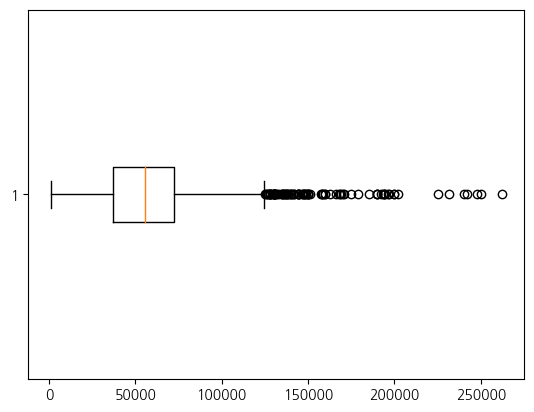

In [108]:
plt.boxplot(df_raw['Kilometers_Driven'].dropna(), vert=False)

'Kilometers_Driven boxplot을 그려서 끝에 있는 9개의 데이터 삭제한 모델

### 범주형 변수 값 확인

In [110]:
# 범주형 변수 - Fuel_Type 빈도 확인 (결측값이 없으므로 이상치만 확인)

df_raw.Fuel_Type.value_counts()

Diesel    1329
Petrol    1121
CNG         18
Name: Fuel_Type, dtype: int64

In [111]:
# 범주형 변수 - Transmission 빈도 확인 (결측값이 없으므로 이상치만 확인)

df_raw.Transmission.value_counts()

Manual       2064
Automatic     404
Name: Transmission, dtype: int64

In [112]:
# 마일리지 변수의 null 값 확인

df_raw[df_raw['Mileage'].isnull()]

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats


-> 4446 행은 Engine 변수에서 72CC 라는 낮은 값을 갖고 있으므로 결측치 대체 대신 행 삭제

-> 나머지 결측값을 채우려고 하니 고려해야할 요소가 많아 행 삭제

In [113]:
df_cleaned = df_raw.dropna(subset = ['Mileage','Engine', 'Power'], inplace=False)

In [114]:
#지워졌는지 확인용

df_cleaned.isnull().sum()

Name                 0
Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Mileage              0
Engine               0
Power                0
Seats                0
dtype: int64

In [115]:
df_cleaned.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats
0,Maruti Wagon R LXI CNG,9,2682.68,2010,72000,CNG,Manual,26.6,998,58.16,5.0
1,Hyundai Creta 1.6 CRDi SX Option,10,19162.00,2015,41000,Diesel,Manual,19.67,1582,126.20,5.0
3,Maruti Ertiga VDI,2,9197.76,2012,87000,Diesel,Manual,20.77,1248,88.76,7.0
6,Nissan Micra Diesel XV,6,5365.36,2013,86999,Diesel,Manual,23.08,1461,63.10,5.0
12,Maruti Swift VDI BSIV,6,8584.58,2015,64424,Diesel,Manual,25.2,1248,74.00,5.0


In [116]:
# 마일리지 변수 타입 변경

df_cleaned['Mileage'] = df_cleaned['Mileage'].astype('float64')

In [117]:
df_cleaned.isnull().sum()

Name                 0
Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Mileage              0
Engine               0
Power                0
Seats                0
dtype: int64

In [118]:
df_cleaned.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats
0,Maruti Wagon R LXI CNG,9,2682.68,2010,72000,CNG,Manual,26.60,998,58.16,5.0
1,Hyundai Creta 1.6 CRDi SX Option,10,19162.00,2015,41000,Diesel,Manual,19.67,1582,126.20,5.0
3,Maruti Ertiga VDI,2,9197.76,2012,87000,Diesel,Manual,20.77,1248,88.76,7.0
6,Nissan Micra Diesel XV,6,5365.36,2013,86999,Diesel,Manual,23.08,1461,63.10,5.0
12,Maruti Swift VDI BSIV,6,8584.58,2015,64424,Diesel,Manual,25.20,1248,74.00,5.0


### 마일리지 변수 이상치

<Axes: ylabel='Mileage'>

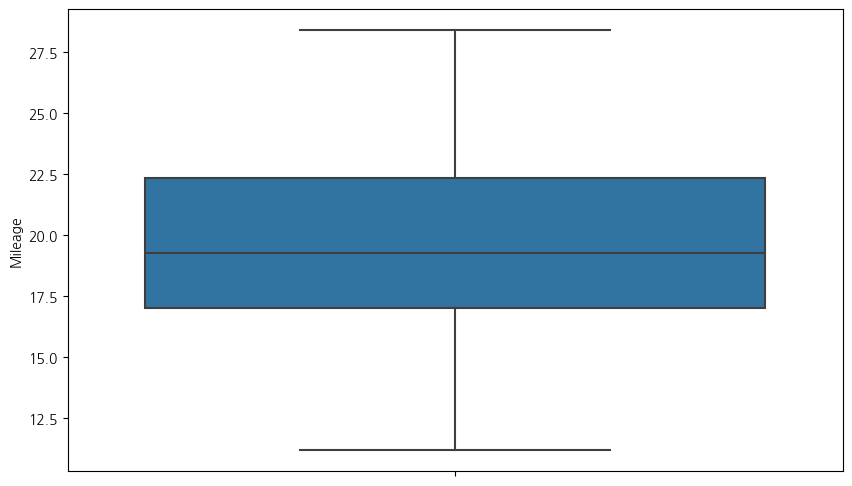

In [119]:
# 마일리지 이상치 확인

plt.figure(figsize=(10, 6))
sns.boxplot(df_cleaned, y='Mileage')

In [120]:
df_cleaned.describe()

,Location,Price,Year,Kilometers_Driven,Mileage,Power,Seats
count,2468.000000,2468.000000,2468.000000,2468.000000,2468.000000,2468.000000,2468.000000
mean,5.551864,11440.964925,2013.448947,58768.514182,19.367095,100.796524,5.293760
std,2.893906,11060.986009,2.519045,31659.574059,3.632696,38.826382,0.739204
min,0.000000,919.780000,2001.000000,1001.000000,11.180000,46.300000,5.000000
25%,3.000000,5212.060000,2012.000000,37285.250000,17.000000,74.000000,5.000000
50%,5.000000,7797.658611,2014.000000,55738.000000,19.270000,86.700000,5.000000
75%,8.000000,12646.920000,2015.000000,72363.250000,22.320000,121.300000,5.000000
max,10.000000,107966.370000,2019.000000,262000.000000,28.400000,241.400000,8.000000


In [121]:
Q1_m = np.percentile(df_cleaned['Mileage'].dropna(), 25)
Q3_m = np.percentile(df_cleaned['Mileage'].dropna(), 75)
IQR_m = Q3_m - Q1_m

# 수염의 경계값 계산
lower_bound = Q1_m - 1.5 * IQR_m
upper_bound = Q3_m + 1.5 * IQR_m
print("박스 최솟값 : %.4f, 박스 최댓값 : %.4f"% (lower_bound, upper_bound))

박스 최솟값 : 9.0200, 박스 최댓값 : 30.3000


In [122]:
# 이상치 값 확인

mileage_na = df_cleaned.query('Mileage > 29.86 | Mileage < 6.5')
mileage_na.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats


In [123]:
# 이상치 행에 있는 Name 변수들 뽑기

mile_name = mileage_na['Name'].unique()
len(mile_name), mile_name

(0, array([], dtype=object))

In [124]:
# Name 변수에 있는 범주값 확인

unique_categories = df_raw['Name'].unique()
unique_categories

array(['Maruti Wagon R LXI CNG', 'Hyundai Creta 1.6 CRDi SX Option',
       'Maruti Ertiga VDI', 'Nissan Micra Diesel XV',
       'Maruti Swift VDI BSIV', 'Honda Amaze S i-Dtech',
       'BMW 3 Series 320d', 'Hyundai i20 1.2 Magna',
       'Maruti Alto K10 2010-2014 VXI',
       'Toyota Innova 2.5 V Diesel 7-seater',
       'Mahindra Ssangyong Rexton RX7',
       'Volkswagen Polo Diesel Trendline 1.2L', 'Maruti Alto LXi',
       'Audi A4 2.0 TDI 177 Bhp Premium Plus', 'Maruti Swift VDI',
       'Hyundai Grand i10 Sportz', 'Renault KWID RXT',
       'Ford Figo Diesel Titanium', 'Audi A4 2.0 TDI Multitronic',
       'Mahindra XUV500 W8 4WD', 'Ford Figo Diesel ZXI',
       'Maruti Ritz VDi', 'Hyundai i10 Sportz 1.2',
       'Toyota Fortuner 4x2 Manual',
       'Ford Ecosport 1.5 DV5 MT Titanium Optional',
       'Mahindra XUV500 W8 2WD', 'Volkswagen Polo Diesel Highline 1.2L',
       'Maruti Wagon R VXI BS IV', 'Hyundai i20 Asta 1.2',
       'Toyota Innova Crysta 2.8 ZX AT', 'BMW 3 Series

In [125]:
# 인덱스 활용하고자 인덱스 변수 생성

mileage_na['index_v'] = mileage_na.index
mileage_na.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats,index_v


In [126]:
category_means = df_cleaned.groupby('Name')['Mileage'].mean().to_dict()

print(category_means)

{'Audi A4 2.0 TDI': 16.55, 'Audi A4 2.0 TDI 177 Bhp Premium Plus': 17.11, 'Audi A4 2.0 TDI Multitronic': 16.55, 'Audi A6 2011-2015 2.0 TDI Premium Plus': 17.68, 'Audi Q7 3.0 TDI Quattro Premium Plus': 12.07, 'BMW 3 Series 320d': 18.563913043478262, 'BMW 3 Series 320d Luxury Line': 20.658, 'BMW 3 Series Luxury Line': 21.76, 'BMW 5 Series 2013-2017 520d Luxury Line': 18.12, 'BMW 5 Series 520d Luxury Line': 22.48, 'BMW X1 sDrive20d': 17.05, 'Chevrolet Beat LS': 18.6, 'Chevrolet Beat LT': 18.44, 'Chevrolet Cruze LTZ': 17.853846153846153, 'Ford EcoSport 1.5 TDCi Titanium': 22.77, 'Ford Ecosport 1.5 DV5 MT Titanium': 22.7, 'Ford Ecosport 1.5 DV5 MT Titanium Optional': 22.7, 'Ford Figo Diesel EXI': 20.0, 'Ford Figo Diesel Titanium': 20.0, 'Ford Figo Diesel ZXI': 20.0, 'Ford Figo Petrol ZXI': 15.6, 'Honda Amaze S i-Dtech': 25.8, 'Honda Amaze S i-Vtech': 18.0, 'Honda Amaze VX i-DTEC': 25.800000000000004, 'Honda Brio S MT': 19.4, 'Honda City 1.5 S MT': 17.0, 'Honda City 1.5 V MT': 17.0, 'Honda C

In [127]:
# mileage_na의 변수에 대한 브랜드 값을 확인하여 그에 맞는 값으로 대체

for k in mileage_na['index_v'] :
    if mileage_na.loc[k, "Name"] in mile_name :
        df_cleaned.loc[k, "Mileage"] = category_means[mileage_na.loc[k, "Name"]]

# 평균값으로 채워진지 확인
df_cleaned.loc[14:14]

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats


<Axes: ylabel='Mileage'>

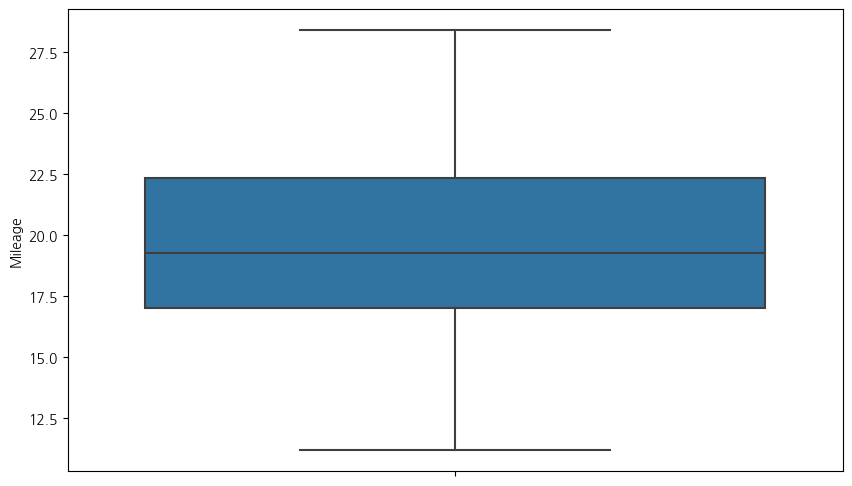

In [128]:
# 마일리지 이상치 확인

plt.figure(figsize=(10, 6))
sns.boxplot(df_cleaned, y='Mileage')

In [129]:
df_cleaned.isnull().sum()

Name                 0
Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Mileage              0
Engine               0
Power                0
Seats                0
dtype: int64

### Engine 변수

In [130]:
df_cleaned['Engine'] = df_cleaned['Engine'].astype('float64')

In [131]:
df_cleaned.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats
0,Maruti Wagon R LXI CNG,9,2682.68,2010,72000,CNG,Manual,26.60,998.0,58.16,5.0
1,Hyundai Creta 1.6 CRDi SX Option,10,19162.00,2015,41000,Diesel,Manual,19.67,1582.0,126.20,5.0
3,Maruti Ertiga VDI,2,9197.76,2012,87000,Diesel,Manual,20.77,1248.0,88.76,7.0
6,Nissan Micra Diesel XV,6,5365.36,2013,86999,Diesel,Manual,23.08,1461.0,63.10,5.0
12,Maruti Swift VDI BSIV,6,8584.58,2015,64424,Diesel,Manual,25.20,1248.0,74.00,5.0


In [132]:
print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2468 entries, 0 to 7251
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               2468 non-null   object 
 1   Location           2468 non-null   int64  
 2   Price              2468 non-null   float64
 3   Year               2468 non-null   int64  
 4   Kilometers_Driven  2468 non-null   int64  
 5   Fuel_Type          2468 non-null   object 
 6   Transmission       2468 non-null   object 
 7   Mileage            2468 non-null   float64
 8   Engine             2468 non-null   float64
 9   Power              2468 non-null   float64
 10  Seats              2468 non-null   float64
dtypes: float64(5), int64(3), object(3)
memory usage: 295.9+ KB
None


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff866c3fdf0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff85f18c0d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff85f18d900>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff85f18c2b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff85f18d240>],
 'means': []}

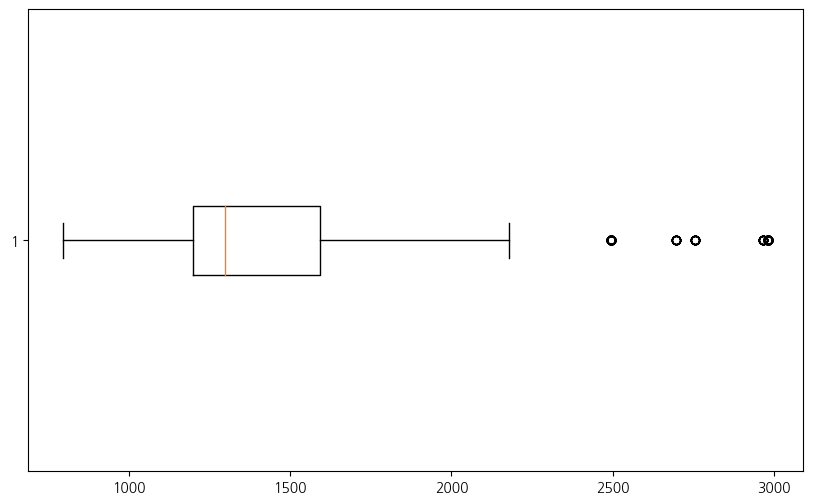

In [133]:
plt.figure(figsize=(10, 6))
plt.boxplot(df_cleaned['Engine'].dropna(), vert=False)

In [134]:
# 사분위수 계산
Q1 = np.percentile(df_cleaned['Engine'].dropna(), 25)
Q3 = np.percentile(df_cleaned['Engine'].dropna(), 75)
IQR = Q3 - Q1

# 수염의 경계값 계산
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#수염보다 큰 값 삭제
df_cleaned = df_cleaned[~(df_cleaned['Engine'] > upper_bound)]

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff85ed264d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff85ed26ad0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff85ed26320>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff85ed27310>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff85ed27490>],
 'means': []}

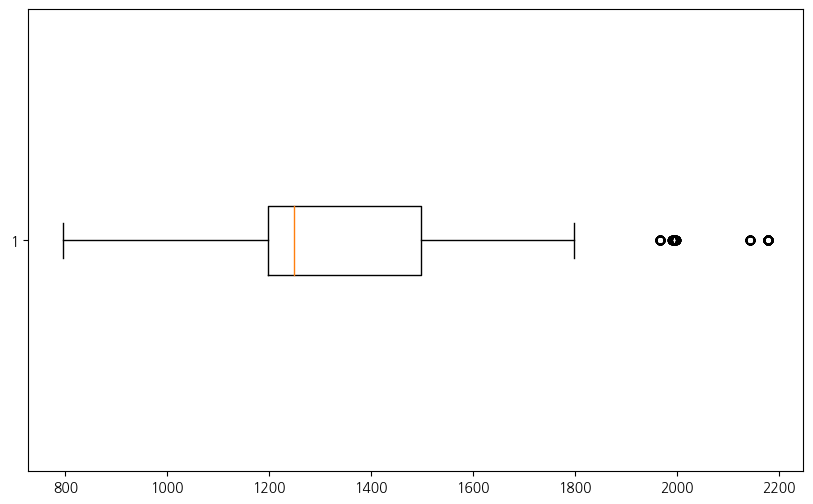

In [135]:
plt.figure(figsize=(10, 6))
plt.boxplot(df_cleaned['Engine'].dropna(), vert=False)

In [136]:
# Name 열의 고유한 값들의 목록을 추출
unique_names = df_cleaned['Name'].unique()

# 고유한 Name 값들의 개수와 목록을 출력
num_unique_names = len(unique_names)

num_unique_names

128

In [137]:
# 결측치(True) 현황 요약 :sum 함수

df_cleaned.isnull().sum()

Name                 0
Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Mileage              0
Engine               0
Power                0
Seats                0
dtype: int64

In [138]:
# 각 열별로 결측치가 있는 행을 출력

for column in df_cleaned.columns:
    missing_rows = df_cleaned[df_cleaned[column].isnull()]
    if not missing_rows.empty:
        print(f"Column '{column}' has missing values in the following rows:")
        print(missing_rows)
        print("\n")

In [139]:
# df_cleaned에서 'Power' 열의 'null' 값을 NaN으로 변환
df_cleaned['Power'] = df_cleaned['Power'].replace('null', np.nan).astype(float)


df_cleaned.head(10)

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats
0,Maruti Wagon R LXI CNG,9,2682.68,2010,72000,CNG,Manual,26.60,998.0,58.16,5.0
1,Hyundai Creta 1.6 CRDi SX Option,10,19162.00,2015,41000,Diesel,Manual,19.67,1582.0,126.20,5.0
3,Maruti Ertiga VDI,2,9197.76,2012,87000,Diesel,Manual,20.77,1248.0,88.76,7.0
6,Nissan Micra Diesel XV,6,5365.36,2013,86999,Diesel,Manual,23.08,1461.0,63.10,5.0
12,Maruti Swift VDI BSIV,6,8584.58,2015,64424,Diesel,Manual,25.20,1248.0,74.00,5.0
16,Honda Amaze S i-Dtech,7,8277.98,2016,58950,Diesel,Manual,25.80,1498.0,98.60,5.0
20,BMW 3 Series 320d,7,28436.41,2014,32982,Diesel,Automatic,22.69,1995.0,190.00,5.0
23,Hyundai i20 1.2 Magna,8,2866.64,2010,45807,Petrol,Manual,18.50,1197.0,80.00,5.0
26,Nissan Micra Diesel XV,5,6515.08,2012,54000,Diesel,Manual,23.08,1461.0,63.10,5.0
27,Maruti Alto K10 2010-2014 VXI,5,4215.64,2013,54000,Petrol,Manual,20.92,998.0,67.10,5.0


In [140]:
# 결측치(True) 현황 요약 :sum 함수
df_cleaned.isnull().sum()

Name                 0
Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Mileage              0
Engine               0
Power                0
Seats                0
dtype: int64